# <div> <center> <b> NN Arabic Handwriting Recognition </b> </center> </div>

## <b> Credentials: </b> (E-JUST Submission)
- Name: Yousef Ibrahim Gomaa Mahmoud
- ID: 320210207
- Group: 1
- Section: AID 3

## <b> Notebook Workflow: </b>
- Environment Setup
- Data Pre-processing
- Data Visualization
- Model Definition
- Training the Model
- Prediction

## <b> Introduction: </b>
<p> In this notebook, a model is to be trained to <b> recognize/classify arabic letters </b> using a convolutional neural network (CNN) through Keras, a TensorFlow tool. </p>

## <b> Dataset: </b>
https://www.kaggle.com/competitions/arabic-letters-classification

## Environment Setup:
### Importing Packages

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### GPU Checkup:
Kaggle provides 2 GPUs which are relied upon heavily during the training phase.

In [2]:
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

: /physical_device:CPU:0
: /physical_device:GPU:0
: /physical_device:GPU:1


### Loading the Dataset(s):

In [3]:
datasets = ['/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/train',\
            '/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/test',
           '/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset']
NUM_CLASS = 65
IMAGE_SIZE = (160,160)
BATCH_SIZE = 512
SEED = 43
EPOCHS = 50

- There are 65 classes to classify into (0-64)
- Images must be resized to a consistent size in order to train properly.

In [4]:
# str = "user001_heh_middle_042.png"
# str[8:18]

## Data Pre-processing:
Splitting training data into 'Training' and 'Validation' for the model to train on.

In [5]:
train_images = tf.keras.utils.image_dataset_from_directory(
    datasets[0],
    validation_split=0.2,
    color_mode='grayscale',
    label_mode="categorical",
    subset="training",
    shuffle=True,
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


Found 42559 files belonging to 65 classes.
Using 34048 files for training.


In [6]:
train_validation = tf.keras.utils.image_dataset_from_directory(
    datasets[0],
    validation_split=0.2,
    label_mode="categorical",
    color_mode='grayscale',
    subset="validation",
    shuffle=True,
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 42559 files belonging to 65 classes.
Using 8511 files for validation.


## Data Visualization:

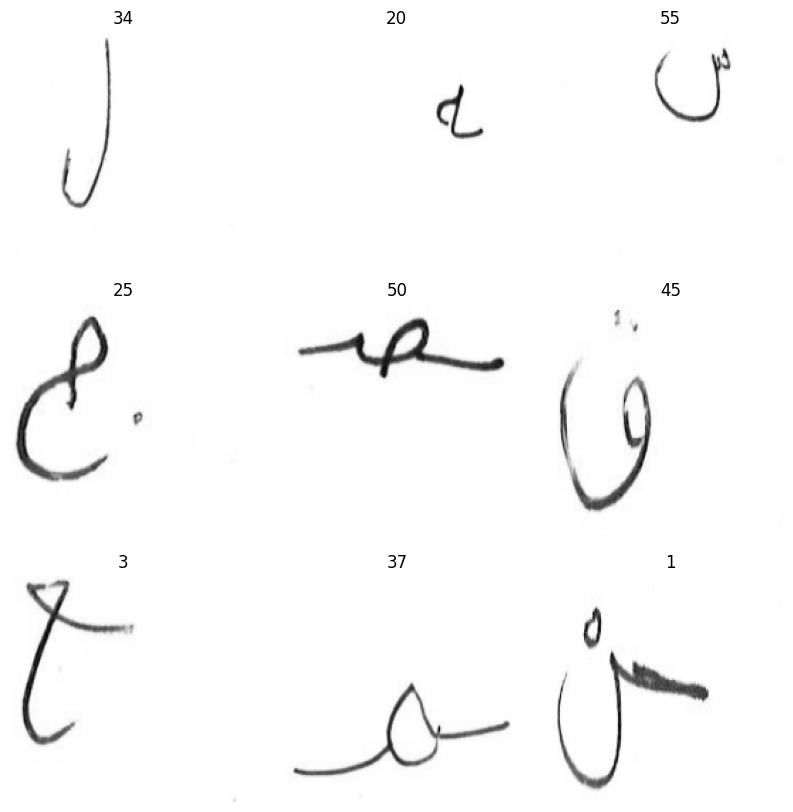

In [40]:
class_names = train_images.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_images.take(1): # Takes a batch and shows the first 9 images
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap=plt.cm.Greys_r)
        plt.title(class_names[np.where(np.array(labels[i])==1)[0][0]])
        plt.axis("off")

In [42]:
for images, labels in train_images:
    print(images.shape)
    print(labels.shape)
    break

(512, 160, 160, 1)
(512, 65)


- (Batch Size, Width, Height, 1 Image Tensor Channel (Greyscale))
- (Batch Size, Number of Classes)

## Model Definition:

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Concatenate, Conv2D, MaxPooling2D, Rescaling, Flatten, Dense, Dropout, Input

# Function to create an Inception block
def inception_block(x, filters):
    # Reduce the number of filters
    branch1x1 = Conv2D(filters // 2, (1, 1), padding='same', activation='relu')(x)
    branch3x3 = Conv2D(filters // 2, (1, 1), padding='same', activation='relu')(x)
    branch3x3 = Conv2D(filters // 2, (3, 3), padding='same', activation='relu')(branch3x3)
    branch5x5 = Conv2D(filters // 2, (1, 1), padding='same', activation='relu')(x)
    branch5x5 = Conv2D(filters // 2, (5, 5), padding='same', activation='relu')(branch5x5)
    branch_pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = Conv2D(filters // 2, (1, 1), padding='same', activation='relu')(branch_pool)

    output = Concatenate()([branch1x1, branch3x3, branch5x5, branch_pool])
    return output


# Input layer
input_layer = Input(shape=(160, 160, 1))

# Rescaling and preprocessing layers
x = Rescaling(1./255)(input_layer)
x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.1)(x)
x = tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)(x)

# Block 1: Standard Conv block
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

# Block 2: Inception block
x = inception_block(x, filters=64)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

# Block 3: Inception block
x = inception_block(x, filters=128)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

# Block 4: Inception block
x = inception_block(x, filters=256)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

# Fully connected layers
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(65, activation='softmax')(x)  # Output for classification

# Model definition
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Print summary of the model
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 160, 160, 1)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 160, 160, 1)          0         ['input_5[0][0]']             
                                                                                                  
 random_rotation_4 (RandomR  (None, 160, 160, 1)          0         ['rescaling_4[0][0]']         
 otation)                                                                                         
                                                                                                  
 random_zoom_4 (RandomZoom)  (None, 160, 160, 1)          0         ['random_rotation_4[0][0

### Model Summary:

In [21]:
model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 160, 160, 1)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 160, 160, 1)          0         ['input_5[0][0]']             
                                                                                                  
 random_rotation_4 (RandomR  (None, 160, 160, 1)          0         ['rescaling_4[0][0]']         
 otation)                                                                                         
                                                                                                  
 random_zoom_4 (RandomZoom)  (None, 160, 160, 1)          0         ['random_rotation_4[0][0

### Model Optimization:

In [22]:
learning_rate = 0.001
lr_mod = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, decay_steps=100000,\
                                                             decay_rate=0.96, staircase=True)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_mod), loss = 'categorical_crossentropy', metrics=['accuracy'])

## Training the Model:

In [23]:
h1 = model.fit(train_images,
              validation_data=train_validation,
              epochs=EPOCHS)

Epoch 1/50
67/67 [==============================] - 100s 1s/step - loss: 4.2695 - accuracy: 0.0154 - val_loss: 4.1745 - val_accuracy: 0.0147
Epoch 2/50
67/67 [==============================] - 69s 999ms/step - loss: 4.1630 - accuracy: 0.0211 - val_loss: 4.0526 - val_accuracy: 0.0619
Epoch 3/50
67/67 [==============================] - 70s 1s/step - loss: 3.8539 - accuracy: 0.0712 - val_loss: 3.4376 - val_accuracy: 0.1445
Epoch 4/50
67/67 [==============================] - 69s 1s/step - loss: 3.3568 - accuracy: 0.1474 - val_loss: 2.4476 - val_accuracy: 0.3465
Epoch 5/50
67/67 [==============================] - 69s 1s/step - loss: 2.5536 - accuracy: 0.2946 - val_loss: 1.6080 - val_accuracy: 0.5503
Epoch 6/50
67/67 [==============================] - 69s 1s/step - loss: 2.0002 - accuracy: 0.4228 - val_loss: 1.2675 - val_accuracy: 0.6233
Epoch 7/50
67/67 [==============================] - 69s 1s/step - loss: 1.6580 - accuracy: 0.5113 - val_loss: 1.0725 - val_accuracy: 0.6816
Epoch 8/50
67/67

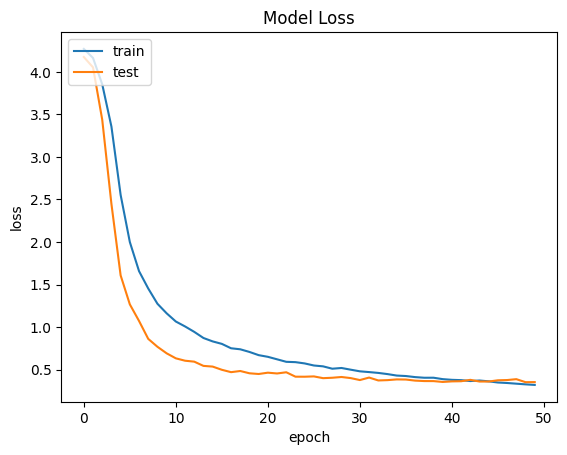

In [24]:
plt.plot(h1.history['loss'])
plt.plot(h1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

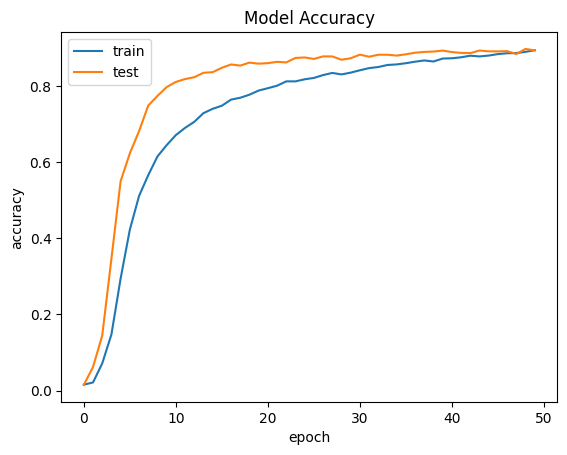

In [25]:
plt.plot(h1.history['accuracy'])
plt.plot(h1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Saving the Model:

Keras format:

In [26]:
model.save('nn-arabic-handwriting-320210207.keras')

### Loading the Model:

In [27]:
model = tf.keras.models.load_model('nn-arabic-handwriting-320210207.keras')

## Prediction:

Loading the 'Test' dataset:

In [28]:
test_images = tf.keras.utils.image_dataset_from_directory(
        datasets[1],
        labels=None,
        label_mode="categorical",
        color_mode='grayscale',
        shuffle=False,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE)

Found 10640 files belonging to 1 classes.


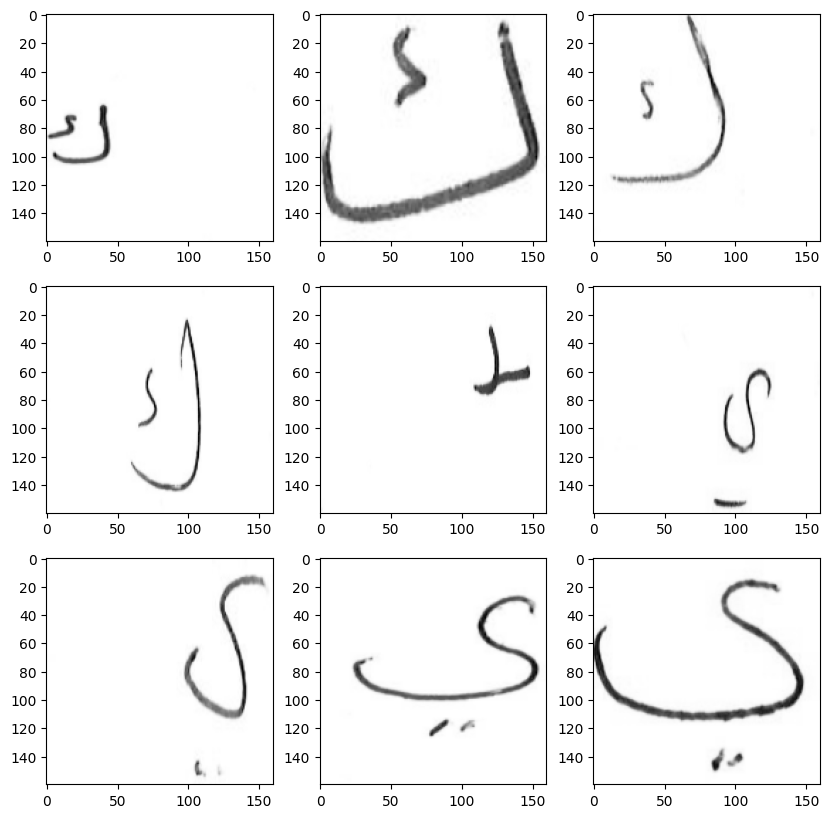

In [29]:
plt.figure(figsize=(10, 10))
for images in test_images.take(1): # Takes a batch and shows the first 9 images
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap=plt.cm.Greys_r)

In [30]:
for images in test_images:
    print(images.shape)
    break

(512, 160, 160, 1)


In [31]:
predictions = model.predict(test_images)

21/21 [==============================] - 24s 1s/step


In [32]:
img_list = os.listdir(datasets[1])

In [33]:
labels_list = sorted(os.listdir(datasets[0]))
print(labels_list)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '7', '8', '9']


In [34]:
predictions[1][22]

0.99998534

## Making 'predictions.csv':

In [35]:
predictions.shape

(10640, 65)

In [36]:
df_predictions = pd.DataFrame(columns=['ID','Label'], dtype=(np.int32,np.int32))

predictions_mod = np.argmax(predictions, 1)

for idx,image in enumerate(sorted(img_list)):
#     print(image, predictions_mod[idx])
    df2 = pd.DataFrame([[int(image.split(".")[0]), int(labels_list[predictions_mod[idx]])]], columns=['ID','Label'])
    df_predictions = pd.concat([df_predictions, df2])

In [37]:
print(predictions_mod)

[22 22 22 ... 61 61 61]


In [38]:
df_predictions.head()

,ID,Label
0,0,29
0,1,29
0,10,29
0,100,29
0,1000,13


In [39]:
df_predictions.sort_values(by='ID', inplace=True)

In [40]:
df_predictions.reset_index(drop=True)

,ID,Label
0,0,29
1,1,29
2,2,29
3,3,29
4,4,29
...,...,...
10635,10635,9
10636,10636,9
10637,10637,9
10638,10638,9


In [41]:
df_predictions.to_csv('predictions.csv', index=False, header=True) 